In [91]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

# Standard Conditions

In [92]:
inchHg= 29.03 # inch Hg for calculating pressure
inchTOm = 25.4 * 1e-3 # inch to m conversion
T = 23.01 + 273.15 # K
g = 9.81 # m/s^2 gravity
R = 287.05 # J/(kg K) specific gas constant of air

# desnity from temperature calculation
rho_Hg = 13595 # kg/m^3 density of mercury
rho_H2O = 1000 # kg/m^3 density of water

P0 =  rho_Hg * g * inchHg * inchTOm # Pa
print(f"The Atmospheric Pressure is {P0} Pa")

# density of air calculation
rho_air = P0 / (R * T) # kg/m^3
print(f"The density of air is {rho_air} kg/m^3")

The Atmospheric Pressure is 98339.7209859 Pa
The density of air is 1.1567646786478845 kg/m^3


In [93]:
oriface_diameter = 17.47 * 1e-3 # mm to m
oriface_area = np.pi * oriface_diameter**2 / 4 # m^2

pipe_area = 10 * oriface_area # ?
print(f"The area of the oriface is {oriface_area} m^2")

# flow rate calculation
Cd = 0.62
def calc_mass_flow_rate(dh):
    dp = rho_H2O * g * dh
    rA = oriface_area / pipe_area
    Q = Cd * oriface_area * np.sqrt(2 * dp / (rho_air * (1 - rA**2))) 
    return rho_air * Q

C1_dh_oriface = 13.2 - 9.6
C2_dh_oriface = 13.7 - 8.8
C3_dh_oriface = 13.7 - 8.8
C4_dh_oriface = 13.7 - 8.8

C1_md = calc_mass_flow_rate(C1_dh_oriface * 1e-2)
C2_md = calc_mass_flow_rate(C2_dh_oriface * 1e-2)
C3_md = calc_mass_flow_rate(C3_dh_oriface * 1e-2)
C4_md = calc_mass_flow_rate(C4_dh_oriface * 1e-2)

print(f"The flow rate for C1 is {C1_md} kg/s")
print(f"The flow rate for C2 is {C2_md} kg/s")
print(f"The flow rate for C3 is {C3_md} kg/s")
print(f"The flow rate for C4 is {C4_md} kg/s")


The area of the oriface is 0.00023970422632724826 m^2
The flow rate for C1 is 0.004269460943203133 kg/s
The flow rate for C2 is 0.004981037767070322 kg/s
The flow rate for C3 is 0.004981037767070322 kg/s
The flow rate for C4 is 0.004981037767070322 kg/s


# Static Pressure graph

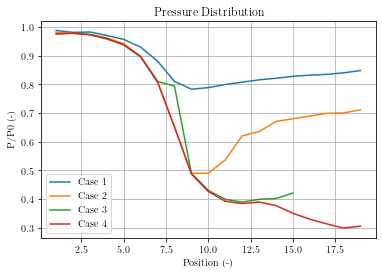

In [94]:
def get_rp(tab):
    dh = (tab[:,2] - tab[:,1]) * 1e-2 # m
    p = P0 - rho_Hg * g * dh

    return p / P0

C1 = np.loadtxt('case1.txt', skiprows=1)
C1_rp = get_rp(C1)
C2 = np.loadtxt('case2.txt', skiprows=1)
C2_rp = get_rp(C2)
C3 = np.loadtxt('case3.txt', skiprows=1)
C3_rp = get_rp(C3)
C4 = np.loadtxt('case4.txt', skiprows=1)
C4_rp = get_rp(C4)

C3_SHOCK_LOCATION = 15

fig,ax = plt.subplots()
x = C1[:,0]
ax.plot(x, C1_rp, label='Case 1')
ax.plot(x, C2_rp, label='Case 2')
ax.plot(x[:C3_SHOCK_LOCATION], C3_rp[:C3_SHOCK_LOCATION] , label='Case 3')
ax.plot(x, C4_rp, label='Case 4')

plt.xlabel('Position (-)')
plt.ylabel('P/P0 (-)')
plt.title('Pressure Distribution')
plt.legend()
plt.grid()
plt.show()

# Mach number graph

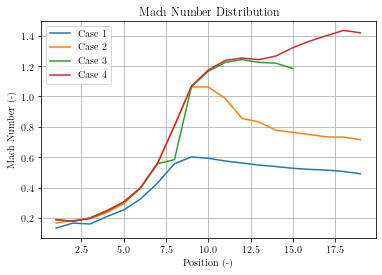

In [95]:

def calc_M(rp):
    # calc mach number from pressure ratio
    g = 1.4
    M2 = (rp ** -((g-1)/g) - 1) * 2 / (g - 1)
    return np.sqrt(M2)

C1_M = calc_M(C1_rp)
C2_M = calc_M(C2_rp)
C3_M = calc_M(C3_rp)
C4_M = calc_M(C4_rp)

fig,ax = plt.subplots()
ax.plot(C1[:,0], C1_M, label='Case 1')
ax.plot(C2[:,0], C2_M, label='Case 2')
ax.plot(C3[:C3_SHOCK_LOCATION,0], C3_M[:C3_SHOCK_LOCATION], label='Case 3')
ax.plot(C4[:,0], C4_M, label='Case 4')

plt.xlabel('Position (-)')
plt.ylabel('Mach Number (-)')
plt.title('Mach Number Distribution')
plt.legend()
plt.grid()
plt.show()


# Continuation of Case 3 from shock location

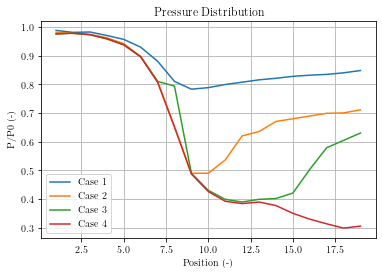

In [96]:

def Ms_from_M(M):
    g = 1.4
    return np.sqrt((1 + (g - 1) / 2 * M**2) / (g * M**2 - (g - 1) / 2))

def rP0s_from_M(M):
    g = 1.4
    return (((g + 1) / 2 * M**2) / (1 + (g - 1) / 2 * M **2)) ** (g / (g - 1)) * (2 * g / (g + 1) * M**2 - (g - 1) / (g + 1)) ** - (1 / (g - 1))


MachNo_before_shock = C3_M[C3_SHOCK_LOCATION - 1]
MachNo_after_shock = Ms_from_M(MachNo_before_shock)

P0s = rP0s_from_M(MachNo_after_shock) * P0

C3_rp_corrected = C3_rp.copy()
C3_rp_corrected[C3_SHOCK_LOCATION:] *= P0 / P0s

fig,ax = plt.subplots()
ax.plot(C1[:,0], C1_rp, label='Case 1')
# add error bars
ax.plot(C2[:,0], C2_rp, label='Case 2')
#ax.plot(C3[:,0], C3_rp, label='Case 3')
ax.plot(C3[:,0], C3_rp_corrected, label='Case 3')
ax.plot(C4[:,0], C4_rp, label='Case 4')

plt.xlabel('Position (-)')
plt.ylabel('P/P0 (-)')
plt.title('Pressure Distribution')
plt.grid()
plt.legend()

plt.savefig('pressure_ratio_distribution_corrected.png', dpi=300)
plt.show()

# Corrected Mach Diagram

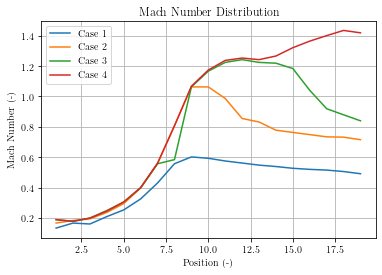

In [97]:

C3_M_corrected = calc_M(C3_rp_corrected)

fig,ax = plt.subplots()
ax.plot(C1[:,0], C1_M, label='Case 1')
ax.plot(C2[:,0], C2_M, label='Case 2')
#ax.plot(C3[:,0], C3_M, label='Case 3')
ax.plot(C3[:,0], C3_M_corrected, label='Case 3')
ax.plot(C4[:,0], C4_M, label='Case 4')

plt.xlabel('Position (-)')
plt.ylabel('Mach Number (-)')
plt.title('Mach Number Distribution')
plt.legend()
plt.grid()
plt.savefig('mach_number_distribution_corrected.png', dpi=300)
plt.show()